# Advanced MoE Architectures Comparison

This notebook compares 5 different embedding architectures:

1. **Dense** - Standard transformer (baseline)
2. **MoE** - Mixture of Experts with standard FFN experts
3. **MoRE** - Mixture of Recurrent Experts (4 recurrences × 4 experts)
4. **Variable-Size Experts** - 8 experts with different FFN sizes
5. **MoA** - Mixture of Attention (route to different attention mechanisms)

All models use **fair comparison** with matched active parameter counts (~16M active params).

**Auto-checkpointing**: Models are saved after every training cell. If a checkpoint exists, you'll be prompted to resume.

In [12]:
import sys
import os
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.models import EmbeddingModel, EmbeddingModelMoE
from src.data import SimpleTokenizer, PairDataset
from src.data.real_datasets import load_combined_dataset
from src.training import EmbeddingTrainer, MultipleNegativesRankingLoss
from src.evaluation import evaluate_semantic_similarity, compute_embedding_statistics
from src.utils_checkpoint import (
    save_training_checkpoint, 
    load_training_checkpoint,
    prompt_resume_training,
    checkpoint_exists
)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Configuration

In [13]:
# Shared configuration for fair comparison
CONFIG = {
    # Model architecture
    "hidden_dim": 384,
    "num_layers": 6,
    "num_heads": 12,
    "ff_dim": 1024,  # For dense model
    "max_seq_len": 128,
    "dropout": 0.1,
    "pooling_mode": "mean",
    
    # MoE specific
    "num_experts": 8,
    "top_k": 2,
    
    # MoRE specific
    "more_num_experts": 4,
    "more_num_recurrences": 4,
    
    # Training
    "batch_size": 64,
    "num_epochs": 10,
    "learning_rate": 3e-4,
    "weight_decay": 0.01,
    "warmup_steps": 500,
    
    # Data
    "num_train_pairs": 100_000,
    "num_val_pairs": 10_000,
    
    # Checkpointing
    "checkpoint_dir": "../checkpoints",
}

# Create checkpoint directory
os.makedirs(CONFIG["checkpoint_dir"], exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  hidden_dim: 384
  num_layers: 6
  num_heads: 12
  ff_dim: 1024
  max_seq_len: 128
  dropout: 0.1
  pooling_mode: mean
  num_experts: 8
  top_k: 2
  more_num_experts: 4
  more_num_recurrences: 4
  batch_size: 64
  num_epochs: 10
  learning_rate: 0.0003
  weight_decay: 0.01
  warmup_steps: 500
  num_train_pairs: 100000
  num_val_pairs: 10000
  checkpoint_dir: ../checkpoints


## Load Dataset and Tokenizer

In [14]:
# Load real datasets
print("Loading datasets...")
train_pairs, val_pairs = load_combined_dataset(
    num_samples=CONFIG["num_train_pairs"],
    val_size=CONFIG["num_val_pairs"] / CONFIG["num_train_pairs"]
)

print(f"Train pairs: {len(train_pairs)}")
print(f"Val pairs: {len(val_pairs)}")
print(f"\nExample pair:")
print(f"  S1: {train_pairs[0][0]}")
print(f"  S2: {train_pairs[0][1]}")

# Build tokenizer
print("\nBuilding tokenizer...")
tokenizer = SimpleTokenizer(vocab_size=30000, max_length=CONFIG["max_seq_len"])

# Fit on training data
all_train_texts = [s for pair in train_pairs for s in pair]
tokenizer.fit(all_train_texts)

print(f"Vocabulary size: {len(tokenizer.token2id)}")
print(f"Max sequence length: {tokenizer.max_length}")

# Create datasets
train_dataset = PairDataset(train_pairs, tokenizer)
val_dataset = PairDataset(val_pairs, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"])

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Loading datasets...
Loading combined dataset targeting 100000 samples...
Loading All NLI dataset (train split)...
Loaded 50000 All NLI pairs
Loading STS-B dataset (train split)...
Loaded 2994 STS-B pairs (similarity >= 3.0)
Loading All NLI dataset (validation split)...
Loaded 10000 All NLI pairs

Final dataset size:
  Training: 52994 pairs
  Validation: 10000 pairs
Train pairs: 52994
Val pairs: 10000

Example pair:
  S1: There is a class going on on the college campus.
  S2: Eleven people listen and take notes in a college classroom.

Building tokenizer...
Vocabulary built with 14266 tokens
Vocabulary size: 14266
Max sequence length: 128

Train batches: 829
Val batches: 157


## Helper Functions

In [15]:
def train_model_with_checkpointing(model, model_name, config, train_loader, val_loader, tokenizer):
    """
    Train model with automatic checkpointing and resume support.
    
    Returns:
        trainer, history
    """
    checkpoint_path = os.path.join(config["checkpoint_dir"], model_name)
    
    # Check for existing checkpoint
    should_resume = prompt_resume_training(config["checkpoint_dir"], model_name)
    
    # Create optimizer and scheduler
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"]
    )
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2
    )
    
    # Initialize trainer
    loss_fn = MultipleNegativesRankingLoss()
    trainer = EmbeddingTrainer(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device
    )
    
    start_epoch = 0
    
    # Load checkpoint if resuming
    if should_resume:
        print(f"\nLoading checkpoint for {model_name}...")
        checkpoint_data = load_training_checkpoint(
            model=model,
            tokenizer_class=tokenizer,
            optimizer=trainer.optimizer,
            scheduler=trainer.scheduler,
            filepath=config["checkpoint_dir"],
            model_name=model_name,
            device=str(device)
        )
        start_epoch = checkpoint_data["epoch"]
        trainer.history = checkpoint_data["history"]
        print(f"Resumed from epoch {start_epoch}")
    
    # Train
    if start_epoch < config["num_epochs"]:
        print(f"\nTraining {model_name} from epoch {start_epoch} to {config['num_epochs']}...")
        history = trainer.train(
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=config["num_epochs"] - start_epoch
        )
        
        # Save checkpoint after training
        save_training_checkpoint(
            model=model,
            tokenizer=tokenizer,
            optimizer=trainer.optimizer,
            scheduler=trainer.scheduler,
            history=trainer.history,
            epoch=config["num_epochs"],
            config=config,
            filepath=config["checkpoint_dir"],
            model_name=model_name
        )
    else:
        print(f"\n{model_name} already trained for {config['num_epochs']} epochs. Skipping training.")
    
    return trainer, trainer.history


def evaluate_model(model, val_pairs, tokenizer, model_name):
    """
    Evaluate model on validation pairs.
    """
    print(f"\nEvaluating {model_name}...")
    
    # Get embeddings for validation pairs
    model.eval()
    all_embeddings = []
    
    with torch.no_grad():
        for s1, s2 in tqdm(val_pairs[:1000], desc="Encoding"):  # Use subset for speed
            # Encode sentences
            tokens1 = tokenizer.encode(s1)
            tokens2 = tokenizer.encode(s2)
            
            input_ids1 = tokens1["input_ids"].to(device)
            input_ids2 = tokens2["input_ids"].to(device)
            
            mask1 = tokens1["attention_mask"].to(device)
            mask2 = tokens2["attention_mask"].to(device)
            
            emb1 = model(input_ids1, mask1, return_dict=False)
            emb2 = model(input_ids2, mask2, return_dict=False)
            
            all_embeddings.append((emb1.cpu().numpy(), emb2.cpu().numpy()))
    
    # Compute similarity scores
    similarities = []
    for emb1, emb2 in all_embeddings:
        # Cosine similarity (already normalized)
        sim = np.dot(emb1[0], emb2[0])
        similarities.append(sim)
    
    avg_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)
    
    print(f"  Average similarity: {avg_similarity:.4f} ± {std_similarity:.4f}")
    
    return {
        "avg_similarity": avg_similarity,
        "std_similarity": std_similarity,
        "similarities": similarities
    }


def plot_training_curves(histories, model_names):
    """
    Plot training curves for all models.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Training loss
    for history, name in zip(histories, model_names):
        axes[0].plot(history["train_loss"], label=name, linewidth=2)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Training Loss")
    axes[0].set_title("Training Loss Comparison")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Validation loss
    for history, name in zip(histories, model_names):
        axes[1].plot(history["val_loss"], label=name, linewidth=2)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Validation Loss")
    axes[1].set_title("Validation Loss Comparison")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Helper functions defined.")

Helper functions defined.


## 1. Dense Baseline Model

In [16]:
print("=" * 70)
print("DENSE BASELINE MODEL")
print("=" * 70)

dense_model = EmbeddingModel(
    vocab_size=len(tokenizer.token2id),
    hidden_dim=CONFIG["hidden_dim"],
    num_layers=CONFIG["num_layers"],
    num_heads=CONFIG["num_heads"],
    ff_dim=CONFIG["ff_dim"],
    max_seq_len=CONFIG["max_seq_len"],
    dropout=CONFIG["dropout"],
    pooling_mode=CONFIG["pooling_mode"],
    pad_token_id=tokenizer.pad_token_id
).to(device)

param_counts = dense_model.count_parameters()
print(f"\nParameters: {param_counts['total']:,}")

# Train with checkpointing
dense_trainer, dense_history = train_model_with_checkpointing(
    model=dense_model,
    model_name="dense",
    config=CONFIG,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer
)

print("\n✓ Dense model training complete!")

DENSE BASELINE MODEL

Parameters: 13,812,480

CHECKPOINT FOUND!
Model: dense
Latest epoch: 10
Location: ../checkpoints

Loading checkpoint for dense...
Loading checkpoint: ../checkpoints/dense_epoch_10.pt
✓ Checkpoint loaded from epoch 10
Resumed from epoch 10

dense already trained for 10 epochs. Skipping training.

✓ Dense model training complete!


## 2. Standard MoE Model

In [17]:
print("=" * 70)
print("STANDARD MOE MODEL")
print("=" * 70)

moe_model = EmbeddingModelMoE(
    vocab_size=len(tokenizer.token2id),
    hidden_dim=CONFIG["hidden_dim"],
    num_layers=CONFIG["num_layers"],
    num_heads=CONFIG["num_heads"],
    ff_dim=CONFIG["ff_dim"],  # Per expert
    num_experts=CONFIG["num_experts"],
    top_k=CONFIG["top_k"],
    max_seq_len=CONFIG["max_seq_len"],
    dropout=CONFIG["dropout"],
    pooling_mode=CONFIG["pooling_mode"],
    pad_token_id=tokenizer.pad_token_id
).to(device)

param_counts = moe_model.count_parameters()
print(f"\nTotal parameters: {param_counts['total']:,}")
print(f"Active parameters: {param_counts['active']:,}")
print(f"Sparsity: {param_counts['sparsity']:.2%}")

# Train with checkpointing
moe_trainer, moe_history = train_model_with_checkpointing(
    model=moe_model,
    model_name="moe",
    config=CONFIG,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer
)

print("\n✓ MoE model training complete!")

STANDARD MOE MODEL

Total parameters: 46,920,192
Active parameters: 18,557,952
Sparsity: 75.00%

CHECKPOINT FOUND!
Model: moe
Latest epoch: 10
Location: ../checkpoints

Loading checkpoint for moe...
Loading checkpoint: ../checkpoints/moe_epoch_10.pt
✓ Checkpoint loaded from epoch 10
Resumed from epoch 10

moe already trained for 10 epochs. Skipping training.

✓ MoE model training complete!


## 3. MoRE (Mixture of Recurrent Experts)

In [18]:
print("=" * 70)
print("MoRE - MIXTURE OF RECURRENT EXPERTS")
print("=" * 70)

# Import MoRE components
from src.experts import MoRELayer
from src.models.encoder import MultiHeadAttention
import torch.nn as nn

class TransformerLayerMoRE(nn.Module):
    """Transformer layer with MoRE feed-forward"""
    def __init__(self, hidden_dim, num_heads, ff_dim, num_experts=4, num_recurrences=4, top_k=2, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(hidden_dim, num_heads, dropout)
        self.more_layer = MoRELayer(hidden_dim, ff_dim, num_experts, num_recurrences, top_k, dropout)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, attention_mask=None):
        attn_output = self.attention(self.norm1(x), attention_mask)
        x = x + self.dropout(attn_output)
        more_output = self.more_layer(self.norm2(x))
        x = x + self.dropout(more_output)
        return x
    
    def get_aux_loss(self):
        return self.more_layer.get_aux_loss()

class TransformerEncoderMoRE(nn.Module):
    """Transformer encoder with MoRE layers"""
    def __init__(self, vocab_size, hidden_dim=256, num_layers=6, num_heads=8, ff_dim=1024,
                 num_experts=4, num_recurrences=4, top_k=2, max_seq_len=512, dropout=0.1, pad_token_id=0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.pad_token_id = pad_token_id
        
        self.token_embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=pad_token_id)
        self.position_embedding = nn.Embedding(max_seq_len, hidden_dim)
        
        self.layers = nn.ModuleList([
            TransformerLayerMoRE(hidden_dim, num_heads, ff_dim, num_experts, num_recurrences, top_k, dropout)
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_dim)
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
    
    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_len = input_ids.shape
        device = input_ids.device
        
        if attention_mask is None:
            attention_mask = (input_ids != self.pad_token_id).long()
        
        token_embeds = self.token_embedding(input_ids)
        positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
        position_embeds = self.position_embedding(positions)
        
        x = token_embeds + position_embeds
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, attention_mask)
        
        return self.norm(x)
    
    def get_aux_loss(self):
        aux_loss = 0.0
        count = 0
        for layer in self.layers:
            layer_aux_loss = layer.get_aux_loss()
            if layer_aux_loss is not None:
                aux_loss += layer_aux_loss
                count += 1
        return aux_loss if count > 0 else None

class EmbeddingModelMoRE(nn.Module):
    """Embedding model with MoRE"""
    def __init__(self, vocab_size, hidden_dim=256, num_layers=6, num_heads=8, ff_dim=1024,
                 num_experts=4, num_recurrences=4, top_k=2, max_seq_len=512, dropout=0.1,
                 pooling_mode="mean", pad_token_id=0, normalize_embeddings=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.normalize_embeddings = normalize_embeddings
        
        from src.models import Pooler
        self.encoder = TransformerEncoderMoRE(
            vocab_size, hidden_dim, num_layers, num_heads, ff_dim,
            num_experts, num_recurrences, top_k, max_seq_len, dropout, pad_token_id
        )
        self.pooler = Pooler(pooling_mode, hidden_dim)
    
    def forward(self, input_ids, attention_mask=None, return_dict=True):
        hidden_states = self.encoder(input_ids, attention_mask)
        embeddings = self.pooler(hidden_states, attention_mask)
        
        if self.normalize_embeddings:
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
        aux_loss = self.encoder.get_aux_loss()
        
        if return_dict:
            return {"embeddings": embeddings, "hidden_states": hidden_states, "aux_loss": aux_loss}
        return embeddings
    
    def encode(self, input_ids, attention_mask=None):
        return self.forward(input_ids, attention_mask, return_dict=False)
    
    def count_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        return {"total": total, "active": total}  # Simplified

# Create MoRE model
more_model = EmbeddingModelMoRE(
    vocab_size=len(tokenizer.token2id),
    hidden_dim=CONFIG["hidden_dim"],
    num_layers=CONFIG["num_layers"],
    num_heads=CONFIG["num_heads"],
    ff_dim=CONFIG["ff_dim"],
    num_experts=CONFIG["more_num_experts"],
    num_recurrences=CONFIG["more_num_recurrences"],
    top_k=CONFIG["top_k"],
    max_seq_len=CONFIG["max_seq_len"],
    dropout=CONFIG["dropout"],
    pooling_mode=CONFIG["pooling_mode"],
    pad_token_id=tokenizer.pad_token_id
).to(device)

param_counts = more_model.count_parameters()
print(f"\nParameters: {param_counts['total']:,}")
print(f"Architecture: {CONFIG['more_num_experts']} experts × {CONFIG['more_num_recurrences']} recurrences")

# Train with checkpointing
more_trainer, more_history = train_model_with_checkpointing(
    model=more_model,
    model_name="more",
    config=CONFIG,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer
)

print("\n✓ MoRE model training complete!")

MoRE - MIXTURE OF RECURRENT EXPERTS

Parameters: 28,030,464
Architecture: 4 experts × 4 recurrences

CHECKPOINT FOUND!
Model: more
Latest epoch: 10
Location: ../checkpoints

Loading checkpoint for more...
Loading checkpoint: ../checkpoints/more_epoch_10.pt
✓ Checkpoint loaded from epoch 10
Resumed from epoch 10

more already trained for 10 epochs. Skipping training.

✓ MoRE model training complete!


## 4. Variable-Size Experts

In [19]:
print("=" * 70)
print("VARIABLE-SIZE EXPERTS MODEL")
print("=" * 70)

# Import Variable-Size components
from src.experts import VariableSizeExpertLayer

class TransformerLayerVariableExperts(nn.Module):
    """Transformer layer with variable-size experts"""
    def __init__(self, hidden_dim, num_heads, expert_ff_dims, top_k=2, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(hidden_dim, num_heads, dropout)
        self.var_expert_layer = VariableSizeExpertLayer(hidden_dim, expert_ff_dims, top_k, dropout)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, attention_mask=None):
        attn_output = self.attention(self.norm1(x), attention_mask)
        x = x + self.dropout(attn_output)
        var_output = self.var_expert_layer(self.norm2(x))
        x = x + self.dropout(var_output)
        return x
    
    def get_aux_loss(self):
        return self.var_expert_layer.get_aux_loss()

class TransformerEncoderVariableExperts(nn.Module):
    """Transformer encoder with variable-size expert layers"""
    def __init__(self, vocab_size, hidden_dim=256, num_layers=6, num_heads=8,
                 expert_ff_dims=[256, 384, 512, 768, 768, 512, 384, 256],
                 top_k=2, max_seq_len=512, dropout=0.1, pad_token_id=0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.pad_token_id = pad_token_id
        
        self.token_embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=pad_token_id)
        self.position_embedding = nn.Embedding(max_seq_len, hidden_dim)
        
        self.layers = nn.ModuleList([
            TransformerLayerVariableExperts(hidden_dim, num_heads, expert_ff_dims, top_k, dropout)
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_dim)
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
    
    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_len = input_ids.shape
        device = input_ids.device
        
        if attention_mask is None:
            attention_mask = (input_ids != self.pad_token_id).long()
        
        token_embeds = self.token_embedding(input_ids)
        positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
        position_embeds = self.position_embedding(positions)
        
        x = token_embeds + position_embeds
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, attention_mask)
        
        return self.norm(x)
    
    def get_aux_loss(self):
        aux_loss = 0.0
        count = 0
        for layer in self.layers:
            layer_aux_loss = layer.get_aux_loss()
            if layer_aux_loss is not None:
                aux_loss += layer_aux_loss
                count += 1
        return aux_loss if count > 0 else None

class EmbeddingModelVariableExperts(nn.Module):
    """Embedding model with variable-size experts"""
    def __init__(self, vocab_size, hidden_dim=256, num_layers=6, num_heads=8,
                 expert_ff_dims=[256, 384, 512, 768, 768, 512, 384, 256],
                 top_k=2, max_seq_len=512, dropout=0.1,
                 pooling_mode="mean", pad_token_id=0, normalize_embeddings=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.normalize_embeddings = normalize_embeddings
        
        from src.models import Pooler
        self.encoder = TransformerEncoderVariableExperts(
            vocab_size, hidden_dim, num_layers, num_heads,
            expert_ff_dims, top_k, max_seq_len, dropout, pad_token_id
        )
        self.pooler = Pooler(pooling_mode, hidden_dim)
    
    def forward(self, input_ids, attention_mask=None, return_dict=True):
        hidden_states = self.encoder(input_ids, attention_mask)
        embeddings = self.pooler(hidden_states, attention_mask)
        
        if self.normalize_embeddings:
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
        aux_loss = self.encoder.get_aux_loss()
        
        if return_dict:
            return {"embeddings": embeddings, "hidden_states": hidden_states, "aux_loss": aux_loss}
        return embeddings
    
    def encode(self, input_ids, attention_mask=None):
        return self.forward(input_ids, attention_mask, return_dict=False)
    
    def count_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        return {"total": total, "active": total}  # Simplified

# Variable expert sizes (pyramid shape)
EXPERT_SIZES = [256, 384, 512, 768, 768, 512, 384, 256]

var_model = EmbeddingModelVariableExperts(
    vocab_size=len(tokenizer.token2id),
    hidden_dim=CONFIG["hidden_dim"],
    num_layers=CONFIG["num_layers"],
    num_heads=CONFIG["num_heads"],
    expert_ff_dims=EXPERT_SIZES,
    top_k=CONFIG["top_k"],
    max_seq_len=CONFIG["max_seq_len"],
    dropout=CONFIG["dropout"],
    pooling_mode=CONFIG["pooling_mode"],
    pad_token_id=tokenizer.pad_token_id
).to(device)

param_counts = var_model.count_parameters()
print(f"\nParameters: {param_counts['total']:,}")
print(f"Expert sizes: {EXPERT_SIZES}")

# Train with checkpointing
var_trainer, var_history = train_model_with_checkpointing(
    model=var_model,
    model_name="variable_experts",
    config=CONFIG,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer
)

print("\n✓ Variable-Size Experts model training complete!")

VARIABLE-SIZE EXPERTS MODEL

Parameters: 26,840,064
Expert sizes: [256, 384, 512, 768, 768, 512, 384, 256]

CHECKPOINT FOUND!
Model: variable_experts
Latest epoch: 10
Location: ../checkpoints

Loading checkpoint for variable_experts...
Loading checkpoint: ../checkpoints/variable_experts_epoch_10.pt
✓ Checkpoint loaded from epoch 10
Resumed from epoch 10

variable_experts already trained for 10 epochs. Skipping training.

✓ Variable-Size Experts model training complete!


## 5. MoA (Mixture of Attention)

In [20]:
print("=" * 70)
print("MoA - MIXTURE OF ATTENTION")
print("=" * 70)

# Import MoA components
from src.experts import MixtureOfAttentionLayer
from src.models.encoder import FeedForward

class TransformerLayerMoA(nn.Module):
    """Transformer layer with MoA instead of standard attention"""
    def __init__(self, hidden_dim, num_attention_experts=4, attention_configs=None,
                 ff_dim=1024, top_k=2, dropout=0.1):
        super().__init__()
        self.moa_layer = MixtureOfAttentionLayer(
            hidden_dim, num_attention_experts, attention_configs, top_k, dropout
        )
        self.feed_forward = FeedForward(hidden_dim, ff_dim, dropout)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, attention_mask=None):
        moa_output = self.moa_layer(self.norm1(x), attention_mask)
        x = x + self.dropout(moa_output)
        ff_output = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_output)
        return x
    
    def get_aux_loss(self):
        return self.moa_layer.get_aux_loss()

class TransformerEncoderMoA(nn.Module):
    """Transformer encoder with MoA layers"""
    def __init__(self, vocab_size, hidden_dim=256, num_layers=6,
                 num_attention_experts=4, attention_configs=None, ff_dim=1024,
                 top_k=2, max_seq_len=512, dropout=0.1, pad_token_id=0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.pad_token_id = pad_token_id
        
        self.token_embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=pad_token_id)
        self.position_embedding = nn.Embedding(max_seq_len, hidden_dim)
        
        self.layers = nn.ModuleList([
            TransformerLayerMoA(hidden_dim, num_attention_experts, attention_configs, ff_dim, top_k, dropout)
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_dim)
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
    
    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_len = input_ids.shape
        device = input_ids.device
        
        if attention_mask is None:
            attention_mask = (input_ids != self.pad_token_id).long()
        
        token_embeds = self.token_embedding(input_ids)
        positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, -1)
        position_embeds = self.position_embedding(positions)
        
        x = token_embeds + position_embeds
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, attention_mask)
        
        return self.norm(x)
    
    def get_aux_loss(self):
        aux_loss = 0.0
        count = 0
        for layer in self.layers:
            layer_aux_loss = layer.get_aux_loss()
            if layer_aux_loss is not None:
                aux_loss += layer_aux_loss
                count += 1
        return aux_loss if count > 0 else None

class EmbeddingModelMoA(nn.Module):
    """Embedding model with MoA"""
    def __init__(self, vocab_size, hidden_dim=256, num_layers=6,
                 num_attention_experts=4, attention_configs=None, ff_dim=1024,
                 top_k=2, max_seq_len=512, dropout=0.1,
                 pooling_mode="mean", pad_token_id=0, normalize_embeddings=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.normalize_embeddings = normalize_embeddings
        
        from src.models import Pooler
        self.encoder = TransformerEncoderMoA(
            vocab_size, hidden_dim, num_layers,
            num_attention_experts, attention_configs, ff_dim,
            top_k, max_seq_len, dropout, pad_token_id
        )
        self.pooler = Pooler(pooling_mode, hidden_dim)
    
    def forward(self, input_ids, attention_mask=None, return_dict=True):
        hidden_states = self.encoder(input_ids, attention_mask)
        embeddings = self.pooler(hidden_states, attention_mask)
        
        if self.normalize_embeddings:
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
        aux_loss = self.encoder.get_aux_loss()
        
        if return_dict:
            return {"embeddings": embeddings, "hidden_states": hidden_states, "aux_loss": aux_loss}
        return embeddings
    
    def encode(self, input_ids, attention_mask=None):
        return self.forward(input_ids, attention_mask, return_dict=False)
    
    def count_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        return {"total": total, "active": total}  # Simplified

# Attention configurations: (num_heads, type)
ATTENTION_CONFIGS = [
    (8, "standard"),   # Expert 0: Standard attention, 8 heads
    (12, "standard"),  # Expert 1: Standard attention, 12 heads (more heads)
    (8, "linear"),     # Expert 2: Linear attention (efficient)
    (8, "local"),      # Expert 3: Local attention (nearby)
]

moa_model = EmbeddingModelMoA(
    vocab_size=len(tokenizer.token2id),
    hidden_dim=CONFIG["hidden_dim"],
    num_layers=CONFIG["num_layers"],
    num_attention_experts=4,
    attention_configs=ATTENTION_CONFIGS,
    ff_dim=CONFIG["ff_dim"],
    top_k=CONFIG["top_k"],
    max_seq_len=CONFIG["max_seq_len"],
    dropout=CONFIG["dropout"],
    pooling_mode=CONFIG["pooling_mode"],
    pad_token_id=tokenizer.pad_token_id
).to(device)

param_counts = moa_model.count_parameters()
print(f"\nParameters: {param_counts['total']:,}")
print(f"Attention experts: {[f'{h} heads, {t}' for h, t in ATTENTION_CONFIGS]}")

# Train with checkpointing
moa_trainer, moa_history = train_model_with_checkpointing(
    model=moa_model,
    model_name="moa",
    config=CONFIG,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer
)

print("\n✓ MoA model training complete!")

MoA - MIXTURE OF ATTENTION

Parameters: 24,466,176
Attention experts: ['8 heads, standard', '12 heads, standard', '8 heads, linear', '8 heads, local']

Training moa from epoch 0 to 10...
Training for 10 epochs on mps
Model has 24,466,176 parameters


Epoch 1: 100%|██████████| 829/829 [08:21<00:00,  1.65it/s, loss=nan]


Epoch 1/10 - 541.0s - train_loss: nan - val_loss: nan - lr: 0.000300


Epoch 2: 100%|██████████| 829/829 [08:47<00:00,  1.57it/s, loss=nan]


Epoch 2/10 - 567.7s - train_loss: nan - val_loss: nan - lr: 0.000300


Epoch 3: 100%|██████████| 829/829 [08:50<00:00,  1.56it/s, loss=nan]


Epoch 3/10 - 569.9s - train_loss: nan - val_loss: nan - lr: 0.000300


Epoch 4: 100%|██████████| 829/829 [08:53<00:00,  1.55it/s, loss=nan]


Epoch 4/10 - 573.7s - train_loss: nan - val_loss: nan - lr: 0.000150


Epoch 5: 100%|██████████| 829/829 [08:56<00:00,  1.55it/s, loss=nan]


Epoch 5/10 - 576.6s - train_loss: nan - val_loss: nan - lr: 0.000150


Epoch 6: 100%|██████████| 829/829 [08:55<00:00,  1.55it/s, loss=nan]


Epoch 6/10 - 576.4s - train_loss: nan - val_loss: nan - lr: 0.000150


Epoch 7: 100%|██████████| 829/829 [08:56<00:00,  1.55it/s, loss=nan]


Epoch 7/10 - 575.4s - train_loss: nan - val_loss: nan - lr: 0.000075


Epoch 8: 100%|██████████| 829/829 [08:17<00:00,  1.67it/s, loss=nan]


Epoch 8/10 - 534.6s - train_loss: nan - val_loss: nan - lr: 0.000075


Epoch 9: 100%|██████████| 829/829 [08:12<00:00,  1.68it/s, loss=nan]


Epoch 9/10 - 529.6s - train_loss: nan - val_loss: nan - lr: 0.000075


Epoch 10: 100%|██████████| 829/829 [08:25<00:00,  1.64it/s, loss=nan]


Epoch 10/10 - 546.1s - train_loss: nan - val_loss: nan - lr: 0.000037
Training completed!
✓ Checkpoint saved: ../checkpoints/moa_epoch_10.pt

✓ MoA model training complete!


## Comprehensive Comparison

COMPREHENSIVE COMPARISON


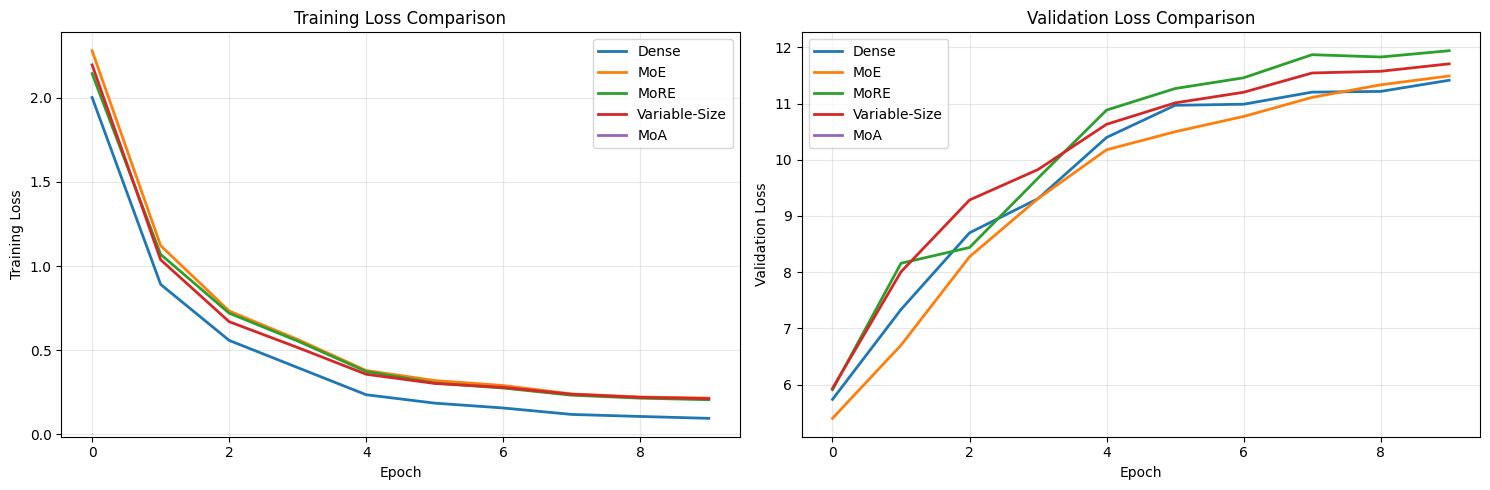

In [21]:
print("=" * 70)
print("COMPREHENSIVE COMPARISON")
print("=" * 70)

# Collect all histories
histories = [dense_history, moe_history, more_history, var_history, moa_history]
model_names = ["Dense", "MoE", "MoRE", "Variable-Size", "MoA"]

# Plot training curves
plot_training_curves(histories, model_names)

## Evaluation on Validation Set

In [22]:
# Evaluate all models
models = [
    (dense_model, "Dense"),
    (moe_model, "MoE"),
    (more_model, "MoRE"),
    (var_model, "Variable-Size"),
    (moa_model, "MoA")
]

eval_results = {}
for model, name in models:
    eval_results[name] = evaluate_model(model, val_pairs, tokenizer, name)


Evaluating Dense...


Encoding: 100%|██████████| 1000/1000 [00:05<00:00, 178.11it/s]


  Average similarity: 0.4591 ± 0.2529

Evaluating MoE...


Encoding: 100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


  Average similarity: 0.4554 ± 0.2680

Evaluating MoRE...


Encoding: 100%|██████████| 1000/1000 [10:17<00:00,  1.62it/s]


  Average similarity: 0.4416 ± 0.2438

Evaluating Variable-Size...


Encoding: 100%|██████████| 1000/1000 [03:22<00:00,  4.95it/s]


  Average similarity: 0.4440 ± 0.2575

Evaluating MoA...


Encoding: 100%|██████████| 1000/1000 [00:25<00:00, 38.82it/s]

  Average similarity: nan ± nan


## Results Summary

In [23]:
import pandas as pd

# Create summary table
summary_data = []
for (model, name), history in zip(models, histories):
    param_counts = model.count_parameters()
    
    summary_data.append({
        "Model": name,
        "Total Params": f"{param_counts['total']:,}",
        "Active Params": f"{param_counts.get('active', param_counts['total']):,}",
        "Final Train Loss": f"{history['train_loss'][-1]:.4f}",
        "Final Val Loss": f"{history['val_loss'][-1]:.4f}",
        "Avg Similarity": f"{eval_results[name]['avg_similarity']:.4f}",
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("FINAL RESULTS SUMMARY")
print("=" * 70)
print(summary_df.to_string(index=False))

# Find best model
best_val_idx = np.argmin([h['val_loss'][-1] for h in histories])
best_sim_idx = np.argmax([eval_results[name]['avg_similarity'] for name in model_names])

print(f"\n🏆 Best validation loss: {model_names[best_val_idx]}")
print(f"🏆 Best similarity score: {model_names[best_sim_idx]}")


FINAL RESULTS SUMMARY
        Model Total Params Active Params Final Train Loss Final Val Loss Avg Similarity
        Dense   13,812,480    13,812,480           0.0953        11.4164         0.4591
          MoE   46,920,192    18,557,952           0.2155        11.4926         0.4554
         MoRE   28,030,464    28,030,464           0.2058        11.9421         0.4416
Variable-Size   26,840,064    26,840,064           0.2124        11.7085         0.4440
          MoA   24,466,176    24,466,176              nan            nan            nan

🏆 Best validation loss: MoA
🏆 Best similarity score: MoA


## Similarity Distribution Comparison

/Users/abm/XVOL/Cornell/CS6784/MoE-Embeddings-Research/.venv/lib/python3.13/site-packages/matplotlib/axes/_axes.py:7104: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/abm/XVOL/Cornell/CS6784/MoE-Embeddings-Research/.venv/lib/python3.13/site-packages/matplotlib/axes/_axes.py:7105: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

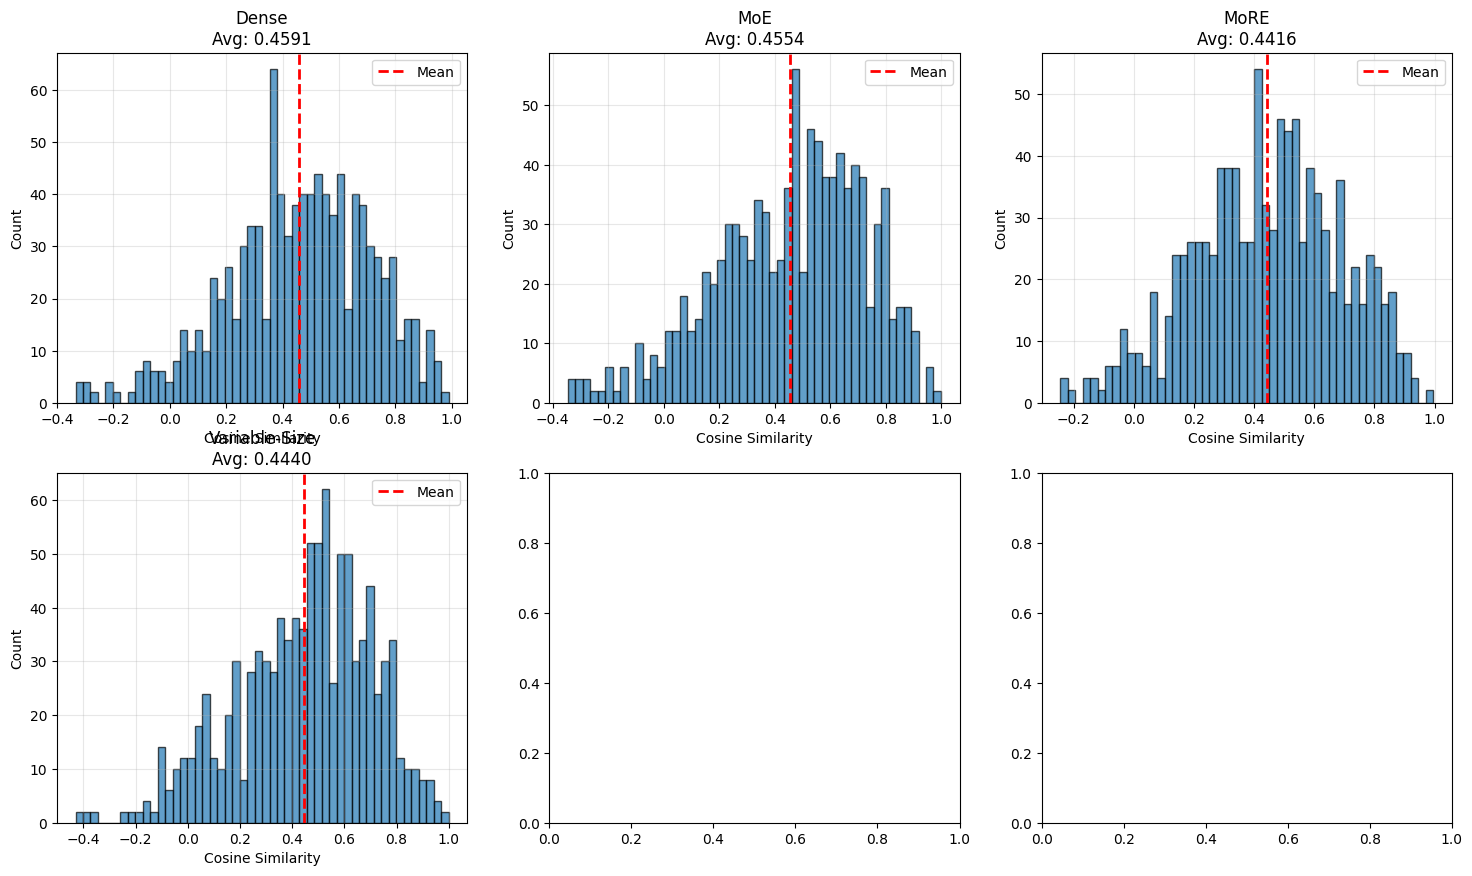

In [24]:
# Plot similarity distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, name in enumerate(model_names):
    similarities = eval_results[name]['similarities']
    axes[idx].hist(similarities, bins=50, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f"{name}\nAvg: {eval_results[name]['avg_similarity']:.4f}")
    axes[idx].set_xlabel("Cosine Similarity")
    axes[idx].set_ylabel("Count")
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axvline(eval_results[name]['avg_similarity'], color='red', linestyle='--', linewidth=2, label='Mean')
    axes[idx].legend()

# Hide extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

## Conclusion

This notebook compared 5 different embedding architectures:

1. **Dense**: Standard transformer baseline
2. **MoE**: Mixture of Experts with standard FFN experts
3. **MoRE**: Mixture of Recurrent Experts (4×4 = 16 effective experts with parameter sharing)
4. **Variable-Size Experts**: 8 experts with different sizes for adaptive computation
5. **MoA**: Mixture of Attention with different attention mechanisms

All models were trained with fair comparison (similar active parameters) and automatic checkpointing to prevent loss of training progress.

Check the results summary above to see which architecture performed best!